In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

In [ ]:
mnist.data.shape

X, y = mnist.data, mnist.target

In [ ]:
X.shape, y.shape

In [ ]:
y

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [ ]:
some_digit = X[0]
some_digit_image = some_digit.reshape((28, 28))
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
print(y[0])

In [ ]:
print(y.dtype)
y = y.astype(np.int)
print(y.dtype)

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) #

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

In [ ]:
# 当用一个随机分类器
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.
This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

#### from sklearn.model_selection import cross_val_predict
Generate cross-validated estimates for each input data point

The data is split according to the cv parameter. Each sample belongs to exactly one test set, and its prediction is computed with an estimator fitted on the corresponding training set.

Passing these predictions into an evaluation metric may not be a valid way to measure generalization performance. Results can differ from cross_validate and cross_val_score unless all tests sets have equal size and the metric decomposes over samples.

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=2)

In [ ]:
# a numpy array
y_train_pred


A much better way to evaluate the performance of a classifier is to look at the confusion matrix.


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_train_5, y_train_pred)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred))

1. The F1 score favors classifiers that have similar precision and recall
2. Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall tradeoff.


可以试着调整threshold来改变precision和recall的偏好，sklearn不让你直接设置threhold. The SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as the predict() method (i.e., True). Let’s raise the threshold:

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold = 0
y_some_digit_threhold = (y_scores > threshold)

In [ ]:

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
print(y_scores)

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    # highlight the threshold, add the legend, axis label and grid
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
print(thresholds)

You may wonder why the precision curve is bumpier than the recall curve
 in Figure 3-4. The reason is that precision may sometimes go down when
  you raise the threshold (although in general it will go up). To
  understand why, look back at Figure 3-3 and notice what happens when
  you start from the central threshold and move it just one digit to the
   right: precision goes from 4/5 (80%) down to 3/4 (75%). On the other
    hand, recall can only go down when the thres‐ hold is increased,
    which explains why its curve looks smooth.

In [ ]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(sgd_clf, X_train, y_train_5)

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

In [ ]:
recall_score(y_train_5, y_train_pred_90)

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    # dashed diagonal [...] # Add axis labels and grid
plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false
 positives (FPR) the classifier produces. The dotted line represents the ROC
 curve of a purely random classifier; a good classifier stays as far away
 from that line as possible (toward the top-left corner).

Since the ROC curve is so similar to the precision/recall (or PR) curve, you
may wonder how to decide which one to use. As a rule of thumb, you should
 prefer the PR curve whenever the positive class is rare or when you care more
  about the false positives than the false negatives, and the ROC curve
  otherwise. For example, looking at the previous ROC curve (and the ROC AUC
   score), you may think that the classifier is really good. But this is mostly
    because there are few positives (5s) compared to the negatives (non-5s).
     In contrast, the PR curve makes it clear that the classifier has room for
      improvement (the curve could be closer to the top- right corner).

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

In [ ]:

from sklearn.ensemble import RandomForestClassifier


forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)


### Multiclass Classification

One-vs-All or one-vs-one

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])


In [ ]:
# sgd是默认one-vs-all
some_digit_score = sgd_clf.decision_function([some_digit])
some_digit_score

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

In [41]:

conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5860,   63,    0,    0,    0,    0,    0,    0,    0,    0],
       [6675,   67,    0,    0,    0,    0,    0,    0,    0,    0],
       [5932,   26,    0,    0,    0,    0,    0,    0,    0,    0],
       [5913,  218,    0,    0,    0,    0,    0,    0,    0,    0],
       [5821,   21,    0,    0,    0,    0,    0,    0,    0,    0],
       [1891, 3530,    0,    0,    0,    0,    0,    0,    0,    0],
       [5796,  122,    0,    0,    0,    0,    0,    0,    0,    0],
       [6251,   14,    0,    0,    0,    0,    0,    0,    0,    0],
       [5741,  110,    0,    0,    0,    0,    0,    0,    0,    0],
       [5903,   46,    0,    0,    0,    0,    0,    0,    0,    0]])

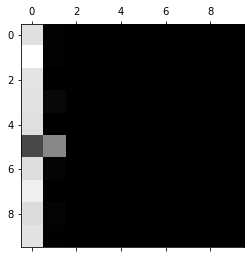

In [42]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()



### Multi label



In [43]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [44]:
knn_clf.predict([some_digit])

array([[False,  True]])